In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error

<Axes: xlabel='Date'>

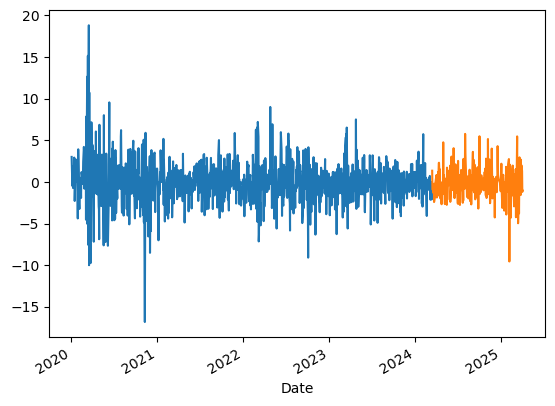

In [2]:
san = pd.read_csv('dane/san.csv', index_col=0, skiprows=2)
san['log_return'] = np.log1p(san.iloc[:,0].pct_change())
san = san.log_return
san.index = pd.to_datetime(san.index, format='%Y-%m-%d')
san.dropna(inplace=True)

ls = 100 * (1 - np.exp(san))
n = ls.size
train, test = ls.iloc[:int(n*0.8)], ls.iloc[int(n*0.8):]
train.plot()
test.plot()

# Historyczna metoda (zwykła)

## VaR(95%)

In [17]:
q95_empirical = train.quantile(0.05)
q95_empirical

-4.191446372816647

## VaR(99%)

In [28]:
q99_empirical = train.quantile(0.01)
q99_empirical

-7.157592011079066

## Dane treningowe

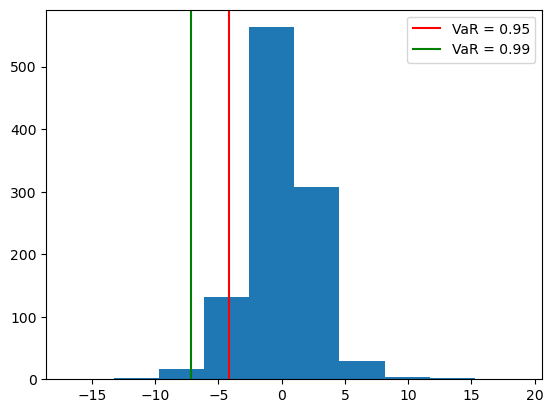

In [34]:
train.hist(grid=False)
plt.axvline(x = q95_empirical, color = 'r', label = 'VaR = 0.95')
plt.axvline(x = q99_empirical, color = 'g', label = 'VaR = 0.99')
plt.legend();

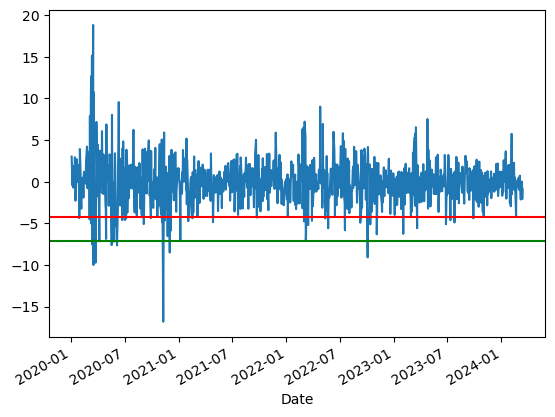

In [37]:
train.plot()
plt.axhline(y=q95_empirical, color='r', linestyle='-', label = 'VaR = 0.95');
plt.axhline(y=q99_empirical, color='g', linestyle='-', label = 'VaR = 0.99');
plt.legend;

## Dane testowe

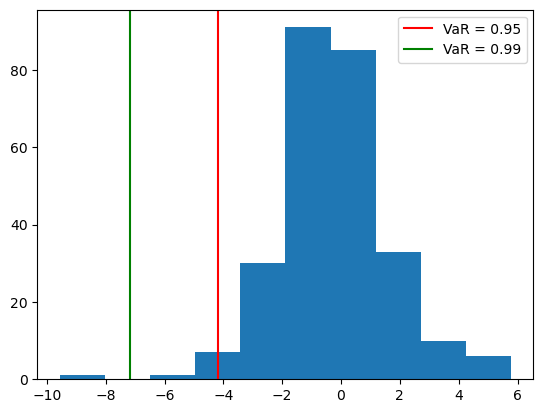

In [39]:
test.hist(grid=False)
plt.axvline(x = q95_empirical, color = 'r', label = 'VaR = 0.95')
plt.axvline(x = q99_empirical, color = 'g', label = 'VaR = 0.99')
plt.legend();

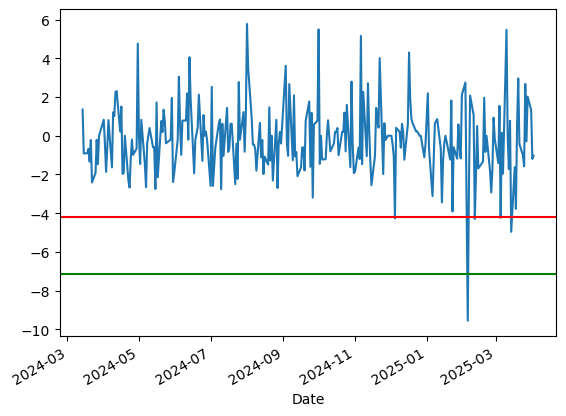

In [40]:
test.plot()
plt.axhline(y=q95_empirical, color='r', linestyle='-', label = 'VaR = 0.95');
plt.axhline(y=q99_empirical, color='g', linestyle='-', label = 'VaR = 0.99');

## VaR(95%)

In [26]:
exceptions95 = train < q95_empirical
exceptions95.head(3)

Date
2020-01-03    False
2020-01-06    False
2020-01-07    False
Name: log_return, dtype: bool

In [27]:
exceptions95.mean()

0.05023696682464455

## VaR(99%)

In [43]:
exceptions99 = train < q99_empirical
exceptions99.mean()

0.01042654028436019

# Historyczna metoda ważona

In [47]:
train_n = len(train)
lam = 0.97
wts_train = [(lam**(i - 1) * (1 - lam)) / (1 - lam**n) for i in range(1, train_n + 1)] 
weights_dict_train = {'Returns':train[::-1], 'Weights': wts_train}
wts_returns_train = pd.DataFrame(weights_dict_train)
sorted_wts_train = wts_returns_train.sort_values(by='Returns')
sorted_wts_train['Cumulative'] = sorted_wts_train.Weights.cumsum()
sorted_wts_train

,Returns,Weights,Cumulative
Date,,,
2020-11-09,-16.822430,2.391147e-13,2.391147e-13
2020-03-17,-10.000021,1.570155e-15,2.406849e-13
2020-03-24,-9.734523,1.828453e-15,2.425133e-13
2022-10-04,-9.090906,5.031730e-07,5.031732e-07
2020-12-01,-8.510636,3.775985e-13,5.031736e-07
...,...,...,...
2020-06-11,9.558831,9.764239e-15,1.000000e+00
2020-03-18,10.743809,1.618716e-15,1.000000e+00
2020-03-09,12.647057,1.307895e-15,1.000000e+00


In [59]:
sorted_wts_train = sorted_wts_train.reset_index(drop=True)

## Var(95%)

In [60]:
sorted_wts_train[sorted_wts_train.Cumulative <= 0.05].Returns.idxmax()

147

In [54]:
sorted_wts_train.loc[147:148]

,Returns,Weights,Cumulative
147,-2.590681,0.000331,0.042084
148,-2.590681,0.012030,0.054115


In [58]:
xp95 = sorted_wts_train.loc[147:148, 'Cumulative'].values
fp95 = sorted_wts_train.loc[147:148, 'Returns'].values
VaR95_weighted = np.interp(0.05, xp95, fp95)
VaR95_weighted

-2.590680952891282

## VaR(99%)

In [61]:
sorted_wts_train[sorted_wts_train.Cumulative <= 0.01].Returns.idxmax()

55

In [62]:
sorted_wts_train.loc[55:56]

,Returns,Weights,Cumulative
55,-4.109590,0.001994,0.003502
56,-4.081638,0.018428,0.021930


In [63]:
xp99 = sorted_wts_train.loc[55:56, 'Cumulative'].values
fp99 = sorted_wts_train.loc[55:56, 'Returns'].values
VaR99_weighted = np.interp(0.05, xp99, fp99)
VaR99_weighted

-4.081637709554697

## Dane testowe

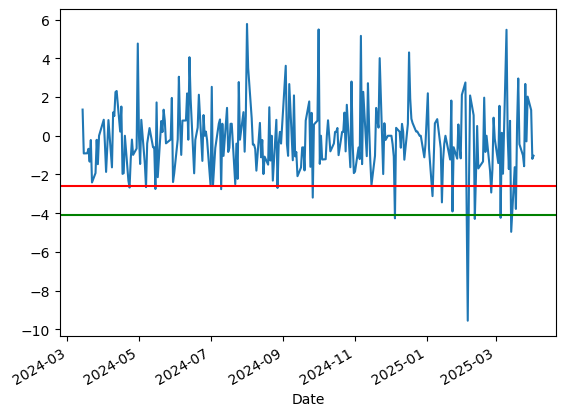

In [64]:
test.plot()
plt.axhline(y=VaR95_weighted, color='r', linestyle='-', label = 'VaR = 0.95');
plt.axhline(y=VaR99_weighted, color='g', linestyle='-', label = 'VaR = 0.99');

## VaR(95%)

In [66]:
exceptions = test < VaR95_weighted
exceptions.mean()

0.07575757575757576

## VaR(99%)

In [67]:
exceptions = test < VaR99_weighted
exceptions.mean()

0.01893939393939394